In [ ]:
import numpy as np
import jax
import jax.numpy as jnp
import jax.nn as jnn
import optax
import matplotlib.pyplot as plt

In [95]:
def triangle_wave(x, p=1):
    return 2 * np.abs(p * x - np.floor(p * x + 0.5)) - 1


def fit_local_polynomials(x, y, partitions, num_partitions, lambda_reg):
    """
    Fit local first-order polynomials for each partition.

    x, y : NumPy arrays or JAX arrays (1D)
    partitions : NumPy array (shape [N, num_partitions]) with POU weights
    lambda_reg : Regularization coefficient
    """
    # Convert x, y, partitions to NumPy if they're JAX arrays, 
    # because we're going to use np.linalg.solve (can also use jax.numpy.linalg if needed).
    x_np = jnp.array(x)
    y_np = jnp.array(y)
    partitions_np = jnp.array(partitions)

    coefficients = []
    for i in range(num_partitions):
        weights = partitions_np[:, i]
        W = jnp.diag(weights)
        X = jnp.vstack([jnp.ones_like(x_np), x_np]).T  # shape [N, 2]
        reg_matrix = lambda_reg * jnp.eye(X.shape[1])

        lhs = X.T @ W @ X + reg_matrix
        rhs = X.T @ W @ y_np
        coeffs = jnp.linalg.solve(lhs, rhs)  # shape (2,)
        coefficients.append(coeffs)

    return jnp.array(coefficients)

def visualize_pou_weights(apply_fn, params, x_train, epoch, phase):
    """
    Visualize partition-of-unity (POU) weights.
      apply_fn: the forward pass function (e.g. apply_res_pou_net)
      params:   the network parameters
      x_train:  1D array of training inputs
    """
    x_jnp = jnp.array(x_train).reshape(-1, 1)  # shape: (N,1)
    with jax.disable_jit():
        partitions = apply_fn(params, x_jnp)  # shape: (N, num_partitions)
    partitions_np = np.array(partitions)

    plt.figure(figsize=(4, 4))
    for i in range(partitions_np.shape[1]):
        plt.plot(x_train, partitions_np[:, i], label=f"Partition {i+1}")
    plt.xlabel("x")
    plt.ylabel("Partition Weight")
    plt.title(f"Phase {phase}, Epoch {epoch}")
    plt.legend()
    plt.ylim([0, 1])
    plt.show()


In [ ]:
def box_init(rng, w_in, w_out, m, delta, L, l):
    p_key, n_key = jax.random.split(rng)
    p = m * jax.random.uniform(p_key, (w_in, w_out))
    n_hat = jax.random.normal(n_key, (w_in, w_out))
    n_norm = jnp.linalg.norm(n_hat, axis=0, keepdims=True) + 1e-9
    n = n_hat / n_norm

    p_max = m * jnp.maximum(jnp.zeros_like(n), jnp.sign(n))
    factor = (L - 1)
    sum_term = jnp.sum((p_max - p) * n, axis=0) + 1e-9
    k = 1.0 / (factor * sum_term)

    A = k * n  # shape (w_in, w_out)
    # IMPORTANT: sum over axis=0 so b has shape (w_out,)
    b = jnp.sum(k * n * p, axis=0)  
    return A, b


def init_linear_layer(rng, in_dim, out_dim, layer_index, total_layers):
    """
    Initialize a single linear layer using box_init.
    layer_index is 0-based, but original code uses (l = idx+1),
    so we do that offset inside this function.
    """
    l = layer_index + 1
    delta = 1.0 / total_layers
    m = (1.0 + 1.0 / (total_layers - 1)) ** l

    A, b = box_init(rng, in_dim, out_dim, m, delta, total_layers, l)
    return {'weight': A, 'bias': b}

def apply_linear_layer(params, x):
    """
    x shape: (batch_size, in_dim)
    params['weight'] shape: (in_dim, out_dim)
    params['bias'] shape:   (out_dim,)
    Return shape: (batch_size, out_dim)
    """
    return x @ params['weight'] + params['bias']

def relu(x):
    return jnp.maximum(0, x)

def init_res_pou_net(rng, input_dim=1, num_partitions=2, hidden_dim=8, depth=8):
    """
    Initialize parameters for the ResPOUNet architecture:
      1) Input layer
      2) (depth-2) 'residual' blocks
      3) Output layer
    We store all layers in a list of parameter dicts.
    """
    layers = []
    # generate separate RNG keys for each layer
    keys = jax.random.split(rng, depth)

    # 1) input layer
    layers.append(init_linear_layer(keys[0], input_dim, hidden_dim, 0, depth))

    # 2) res blocks
    for i in range(1, depth - 1):
        layers.append(init_linear_layer(keys[i], hidden_dim, hidden_dim, i, depth))

    # 3) output layer
    layers.append(init_linear_layer(keys[depth - 1], hidden_dim, num_partitions, depth - 1, depth))

    return layers

def apply_res_pou_net(params, x):
    """
    Forward pass through ResPOUNet:
      - input layer
      - (depth - 2) res blocks
      - output layer
      - softmax
    params is a list of dicts (one per layer).
    x shape: (batch_size, input_dim)
    """
    # 1) Input layer
    out = apply_linear_layer(params[0], x)
    out = relu(out)

    # 2) Res blocks
    for i in range(1, len(params) - 1):
        residual = out
        out = apply_linear_layer(params[i], out)
        out = relu(out)
        out = out + residual

    # 3) Output layer
    out = apply_linear_layer(params[-1], out)

    # Softmax
    out = jax.nn.softmax(out, axis=-1)
    return out


In [86]:
from jax import jit
def train_two_phase_lsgd(params,
                         x_train,
                         y_train,
                         num_partitions=2,
                         num_epochs_phase1=1000,
                         num_epochs_phase2=3000,
                         lambda_reg=0.1,
                         rho=0.99,
                         n_stag=200,
                         lr_phase1=0.1,
                         lr_phase2=0.05):
    """
    Two-phase LSGD training in JAX/optax style.
    params : list of layer parameter dicts (from init_res_pou_net)
    x_train, y_train : 1D arrays
    """
    # We'll define a loss function that does:
    # 1) forward pass => partitions
    # 2) fit local polynomials => coefficients
    # 3) combine => y_pred
    # 4) return MSE

    # JIT compile the loss function
    @jit
    def loss_fn(p, x, y, reg_lambda):
        x_batch = x.reshape(-1, 1)
        partitions = apply_res_pou_net(p, x_batch)
        partitions_np = jnp.array(partitions)
        coeffs = fit_local_polynomials(jnp.array(x), jnp.array(y), partitions_np, num_partitions, reg_lambda)
        y_pred = jnp.zeros_like(y)
        for i in range(num_partitions):
            c0, c1 = coeffs[i]
            y_pred += partitions[:, i] * (c0 + c1 * x)
        return jnp.mean((y_pred - y) ** 2)

    # JIT compile the gradient function
    @jit
    def grad_fn(p, reg_lambda):
        return jax.grad(loss_fn)(p, x_jnp, y_jnp, reg_lambda)

    # Prepare data as jax arrays
    x_jnp = jnp.array(x_train)
    y_jnp = jnp.array(y_train)

    # We'll track best_loss globally across both phases
    best_loss = float('inf')
    stagnation_counter = 0

    # Two-phase approach
    for phase in range(2):
        if phase == 0:
            reg_lambda = lambda_reg
            learning_rate = lr_phase1
            num_epochs = num_epochs_phase1
        else:
            reg_lambda = 0.0  # second phase: 0
            learning_rate = lr_phase2
            num_epochs = num_epochs_phase2

        # Create a new optimizer for each phase
        optimizer = optax.adam(learning_rate)
        opt_state = optimizer.init(params)

        for epoch in range(num_epochs):
            # Compute gradient
            grads = grad_fn(params, reg_lambda)
            # Apply updates
            updates, opt_state = optimizer.update(grads, opt_state)
            params = optax.apply_updates(params, updates)

            # Evaluate current loss
            current_loss = loss_fn(params, x_jnp, y_jnp, reg_lambda)

            # Check stagnation
            if current_loss < best_loss:
                best_loss = current_loss
                stagnation_counter = 0
            else:
                stagnation_counter += 1

            if stagnation_counter > n_stag:
                reg_lambda = reg_lambda * rho
                stagnation_counter = 0

            # Visualization and logging (optional)
            if phase == 0:
                # Automatically determine intervals to visualize based on total epochs
                interval = num_epochs // 10  # Divide total epochs into 10 intervals
                if epoch % interval == 0:
                    visualize_pou_weights(apply_res_pou_net, params, x_train, epoch, phase+1)
                
                # Print the log every epoch
                if epoch % 10 == 0:
                    print(f"Phase {phase+1}, Epoch {epoch}, "
                        f"Loss: {float(current_loss):.6f}, λ: {reg_lambda:.6f}")
            else:
                # Similarly, for phase 2, we do the same automatic interval-based visualization
                interval = num_epochs // 10  # Divide total epochs into 10 intervals
                if epoch % interval == 0:
                    visualize_pou_weights(apply_res_pou_net, params, x_train, epoch, phase+1)
                
                # Print the log every 10 epochs
                if epoch % 10 == 0:
                    print(f"Phase {phase+1}, Epoch {epoch}, "
                        f"Loss: {float(current_loss):.6f}, λ: {reg_lambda:.6f}")

    return params


[cuda(id=0)]


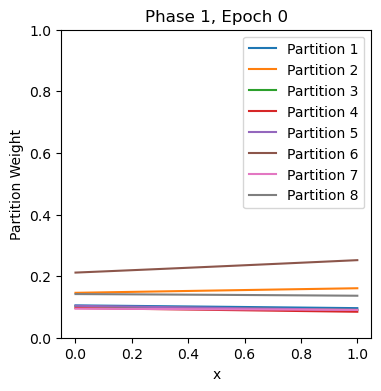

Phase 1, Epoch 0, Loss: 0.025827, λ: 0.400000
Phase 1, Epoch 10, Loss: 0.024903, λ: 0.400000
Phase 1, Epoch 20, Loss: 0.023597, λ: 0.400000
Phase 1, Epoch 30, Loss: 0.021838, λ: 0.400000
Phase 1, Epoch 40, Loss: 0.019711, λ: 0.400000
Phase 1, Epoch 50, Loss: 0.017534, λ: 0.400000
Phase 1, Epoch 60, Loss: 0.015707, λ: 0.400000
Phase 1, Epoch 70, Loss: 0.014384, λ: 0.400000
Phase 1, Epoch 80, Loss: 0.013282, λ: 0.400000
Phase 1, Epoch 90, Loss: 0.011806, λ: 0.400000
Phase 1, Epoch 100, Loss: 0.009627, λ: 0.400000
Phase 1, Epoch 110, Loss: 0.007347, λ: 0.400000
Phase 1, Epoch 120, Loss: 0.005766, λ: 0.400000
Phase 1, Epoch 130, Loss: 0.004950, λ: 0.400000
Phase 1, Epoch 140, Loss: 0.004579, λ: 0.400000
Phase 1, Epoch 150, Loss: 0.004408, λ: 0.400000
Phase 1, Epoch 160, Loss: 0.004321, λ: 0.400000
Phase 1, Epoch 170, Loss: 0.004272, λ: 0.400000
Phase 1, Epoch 180, Loss: 0.004242, λ: 0.400000
Phase 1, Epoch 190, Loss: 0.004220, λ: 0.400000


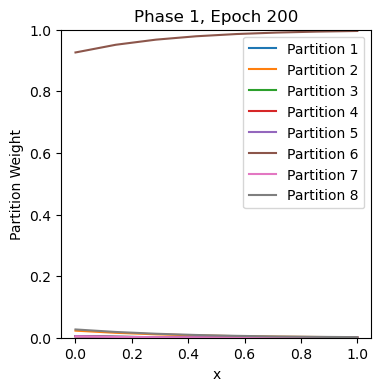

Phase 1, Epoch 200, Loss: 0.004205, λ: 0.400000
Phase 1, Epoch 210, Loss: 0.004195, λ: 0.400000
Phase 1, Epoch 220, Loss: 0.004186, λ: 0.400000
Phase 1, Epoch 230, Loss: 0.004179, λ: 0.400000
Phase 1, Epoch 240, Loss: 0.004174, λ: 0.400000
Phase 1, Epoch 250, Loss: 0.004170, λ: 0.400000
Phase 1, Epoch 260, Loss: 0.004165, λ: 0.400000
Phase 1, Epoch 270, Loss: 0.004162, λ: 0.400000
Phase 1, Epoch 280, Loss: 0.004159, λ: 0.400000
Phase 1, Epoch 290, Loss: 0.004156, λ: 0.400000
Phase 1, Epoch 300, Loss: 0.004155, λ: 0.400000
Phase 1, Epoch 310, Loss: 0.004153, λ: 0.400000
Phase 1, Epoch 320, Loss: 0.004151, λ: 0.400000
Phase 1, Epoch 330, Loss: 0.004150, λ: 0.400000
Phase 1, Epoch 340, Loss: 0.004149, λ: 0.400000
Phase 1, Epoch 350, Loss: 0.004148, λ: 0.400000
Phase 1, Epoch 360, Loss: 0.004146, λ: 0.400000
Phase 1, Epoch 370, Loss: 0.004144, λ: 0.400000
Phase 1, Epoch 380, Loss: 0.004144, λ: 0.400000
Phase 1, Epoch 390, Loss: 0.004143, λ: 0.400000


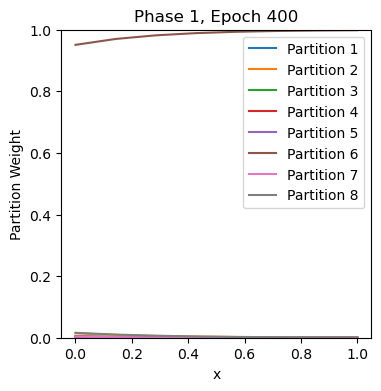

Phase 1, Epoch 400, Loss: 0.004142, λ: 0.400000
Phase 1, Epoch 410, Loss: 0.004142, λ: 0.400000
Phase 1, Epoch 420, Loss: 0.004141, λ: 0.400000
Phase 1, Epoch 430, Loss: 0.004140, λ: 0.400000
Phase 1, Epoch 440, Loss: 0.004139, λ: 0.400000
Phase 1, Epoch 450, Loss: 0.004139, λ: 0.400000
Phase 1, Epoch 460, Loss: 0.004139, λ: 0.400000
Phase 1, Epoch 470, Loss: 0.004138, λ: 0.400000
Phase 1, Epoch 480, Loss: 0.004138, λ: 0.400000
Phase 1, Epoch 490, Loss: 0.004137, λ: 0.400000
Phase 1, Epoch 500, Loss: 0.004136, λ: 0.400000
Phase 1, Epoch 510, Loss: 0.004135, λ: 0.400000
Phase 1, Epoch 520, Loss: 0.004134, λ: 0.400000
Phase 1, Epoch 530, Loss: 0.004133, λ: 0.400000
Phase 1, Epoch 540, Loss: 0.004133, λ: 0.400000
Phase 1, Epoch 550, Loss: 0.004133, λ: 0.400000
Phase 1, Epoch 560, Loss: 0.004132, λ: 0.400000
Phase 1, Epoch 570, Loss: 0.004132, λ: 0.400000
Phase 1, Epoch 580, Loss: 0.004131, λ: 0.400000
Phase 1, Epoch 590, Loss: 0.004130, λ: 0.400000


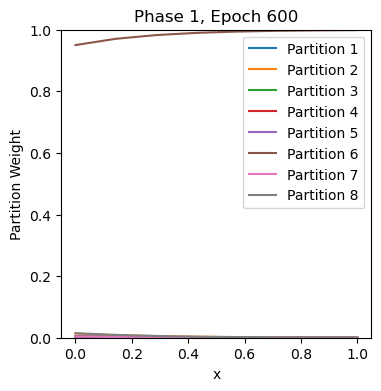

Phase 1, Epoch 600, Loss: 0.004130, λ: 0.400000
Phase 1, Epoch 610, Loss: 0.004129, λ: 0.400000
Phase 1, Epoch 620, Loss: 0.004128, λ: 0.400000
Phase 1, Epoch 630, Loss: 0.004127, λ: 0.400000
Phase 1, Epoch 640, Loss: 0.004126, λ: 0.400000
Phase 1, Epoch 650, Loss: 0.004126, λ: 0.400000
Phase 1, Epoch 660, Loss: 0.004125, λ: 0.400000
Phase 1, Epoch 670, Loss: 0.004124, λ: 0.400000
Phase 1, Epoch 680, Loss: 0.004124, λ: 0.400000
Phase 1, Epoch 690, Loss: 0.004123, λ: 0.400000
Phase 1, Epoch 700, Loss: 0.004122, λ: 0.400000
Phase 1, Epoch 710, Loss: 0.004121, λ: 0.400000
Phase 1, Epoch 720, Loss: 0.004120, λ: 0.400000
Phase 1, Epoch 730, Loss: 0.004119, λ: 0.400000
Phase 1, Epoch 740, Loss: 0.004118, λ: 0.400000
Phase 1, Epoch 750, Loss: 0.004117, λ: 0.400000
Phase 1, Epoch 760, Loss: 0.004116, λ: 0.400000
Phase 1, Epoch 770, Loss: 0.004115, λ: 0.400000
Phase 1, Epoch 780, Loss: 0.004114, λ: 0.400000
Phase 1, Epoch 790, Loss: 0.004113, λ: 0.400000


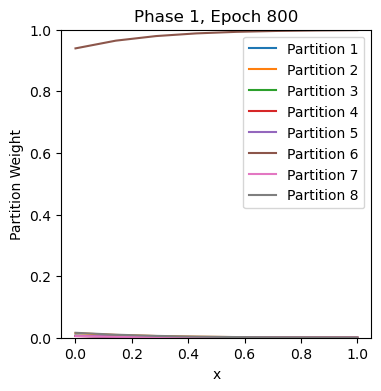

Phase 1, Epoch 800, Loss: 0.004112, λ: 0.400000
Phase 1, Epoch 810, Loss: 0.004110, λ: 0.400000
Phase 1, Epoch 820, Loss: 0.004109, λ: 0.400000
Phase 1, Epoch 830, Loss: 0.004108, λ: 0.400000
Phase 1, Epoch 840, Loss: 0.004106, λ: 0.400000
Phase 1, Epoch 850, Loss: 0.004105, λ: 0.400000
Phase 1, Epoch 860, Loss: 0.004103, λ: 0.400000
Phase 1, Epoch 870, Loss: 0.004102, λ: 0.400000
Phase 1, Epoch 880, Loss: 0.004101, λ: 0.400000
Phase 1, Epoch 890, Loss: 0.004099, λ: 0.400000
Phase 1, Epoch 900, Loss: 0.004097, λ: 0.400000
Phase 1, Epoch 910, Loss: 0.004095, λ: 0.400000
Phase 1, Epoch 920, Loss: 0.004093, λ: 0.400000
Phase 1, Epoch 930, Loss: 0.004092, λ: 0.400000
Phase 1, Epoch 940, Loss: 0.004090, λ: 0.400000
Phase 1, Epoch 950, Loss: 0.004089, λ: 0.400000
Phase 1, Epoch 960, Loss: 0.004087, λ: 0.400000
Phase 1, Epoch 970, Loss: 0.004084, λ: 0.400000
Phase 1, Epoch 980, Loss: 0.004082, λ: 0.400000
Phase 1, Epoch 990, Loss: 0.004080, λ: 0.400000


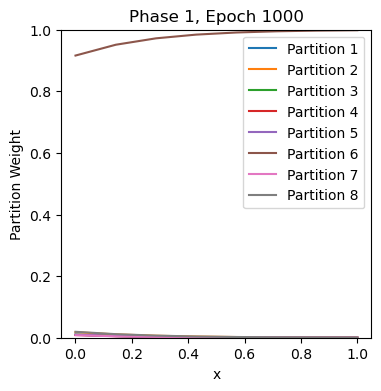

Phase 1, Epoch 1000, Loss: 0.004077, λ: 0.400000
Phase 1, Epoch 1010, Loss: 0.004075, λ: 0.400000
Phase 1, Epoch 1020, Loss: 0.004073, λ: 0.400000
Phase 1, Epoch 1030, Loss: 0.004070, λ: 0.400000
Phase 1, Epoch 1040, Loss: 0.004069, λ: 0.400000
Phase 1, Epoch 1050, Loss: 0.004066, λ: 0.400000
Phase 1, Epoch 1060, Loss: 0.004063, λ: 0.400000
Phase 1, Epoch 1070, Loss: 0.004060, λ: 0.400000
Phase 1, Epoch 1080, Loss: 0.004057, λ: 0.400000
Phase 1, Epoch 1090, Loss: 0.004054, λ: 0.400000
Phase 1, Epoch 1100, Loss: 0.004051, λ: 0.400000
Phase 1, Epoch 1110, Loss: 0.004047, λ: 0.400000
Phase 1, Epoch 1120, Loss: 0.004044, λ: 0.400000
Phase 1, Epoch 1130, Loss: 0.004040, λ: 0.400000
Phase 1, Epoch 1140, Loss: 0.004035, λ: 0.400000
Phase 1, Epoch 1150, Loss: 0.004032, λ: 0.400000
Phase 1, Epoch 1160, Loss: 0.004027, λ: 0.400000
Phase 1, Epoch 1170, Loss: 0.004022, λ: 0.400000
Phase 1, Epoch 1180, Loss: 0.004018, λ: 0.400000
Phase 1, Epoch 1190, Loss: 0.004013, λ: 0.400000


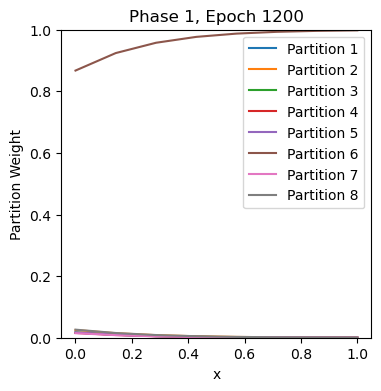

Phase 1, Epoch 1200, Loss: 0.004007, λ: 0.400000
Phase 1, Epoch 1210, Loss: 0.004002, λ: 0.400000
Phase 1, Epoch 1220, Loss: 0.003996, λ: 0.400000
Phase 1, Epoch 1230, Loss: 0.003989, λ: 0.400000
Phase 1, Epoch 1240, Loss: 0.003982, λ: 0.400000
Phase 1, Epoch 1250, Loss: 0.003975, λ: 0.400000
Phase 1, Epoch 1260, Loss: 0.003968, λ: 0.400000
Phase 1, Epoch 1270, Loss: 0.003960, λ: 0.400000
Phase 1, Epoch 1280, Loss: 0.003953, λ: 0.400000
Phase 1, Epoch 1290, Loss: 0.003945, λ: 0.400000
Phase 1, Epoch 1300, Loss: 0.003939, λ: 0.400000
Phase 1, Epoch 1310, Loss: 0.003931, λ: 0.400000
Phase 1, Epoch 1320, Loss: 0.003922, λ: 0.400000
Phase 1, Epoch 1330, Loss: 0.003914, λ: 0.400000
Phase 1, Epoch 1340, Loss: 0.003905, λ: 0.400000
Phase 1, Epoch 1350, Loss: 0.003896, λ: 0.400000
Phase 1, Epoch 1360, Loss: 0.003886, λ: 0.400000
Phase 1, Epoch 1370, Loss: 0.003876, λ: 0.400000
Phase 1, Epoch 1380, Loss: 0.003864, λ: 0.400000
Phase 1, Epoch 1390, Loss: 0.003853, λ: 0.400000


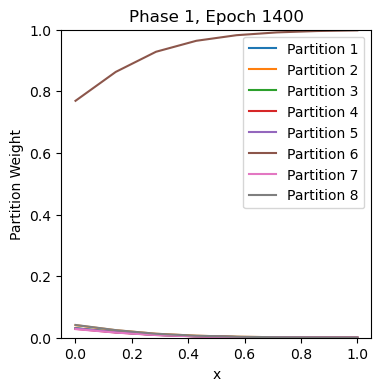

Phase 1, Epoch 1400, Loss: 0.003840, λ: 0.400000
Phase 1, Epoch 1410, Loss: 0.003826, λ: 0.400000
Phase 1, Epoch 1420, Loss: 0.003812, λ: 0.400000
Phase 1, Epoch 1430, Loss: 0.003797, λ: 0.400000
Phase 1, Epoch 1440, Loss: 0.003782, λ: 0.400000
Phase 1, Epoch 1450, Loss: 0.003764, λ: 0.400000
Phase 1, Epoch 1460, Loss: 0.003746, λ: 0.400000
Phase 1, Epoch 1470, Loss: 0.003727, λ: 0.400000
Phase 1, Epoch 1480, Loss: 0.003706, λ: 0.400000
Phase 1, Epoch 1490, Loss: 0.003684, λ: 0.400000
Phase 1, Epoch 1500, Loss: 0.003660, λ: 0.400000
Phase 1, Epoch 1510, Loss: 0.003634, λ: 0.400000
Phase 1, Epoch 1520, Loss: 0.003607, λ: 0.400000
Phase 1, Epoch 1530, Loss: 0.003578, λ: 0.400000
Phase 1, Epoch 1540, Loss: 0.003546, λ: 0.400000
Phase 1, Epoch 1550, Loss: 0.003513, λ: 0.400000
Phase 1, Epoch 1560, Loss: 0.003479, λ: 0.400000
Phase 1, Epoch 1570, Loss: 0.003442, λ: 0.400000
Phase 1, Epoch 1580, Loss: 0.003406, λ: 0.400000
Phase 1, Epoch 1590, Loss: 0.003369, λ: 0.400000


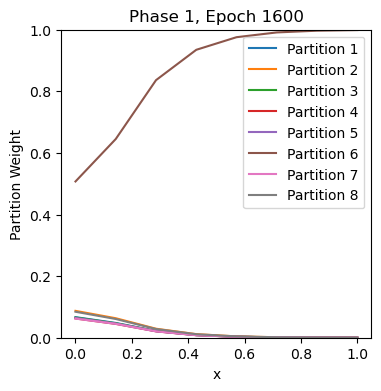

Phase 1, Epoch 1600, Loss: 0.003330, λ: 0.400000
Phase 1, Epoch 1610, Loss: 0.003291, λ: 0.400000
Phase 1, Epoch 1620, Loss: 0.003252, λ: 0.400000
Phase 1, Epoch 1630, Loss: 0.003212, λ: 0.400000
Phase 1, Epoch 1640, Loss: 0.003172, λ: 0.400000
Phase 1, Epoch 1650, Loss: 0.003136, λ: 0.400000
Phase 1, Epoch 1660, Loss: 0.003101, λ: 0.400000
Phase 1, Epoch 1670, Loss: 0.003068, λ: 0.400000
Phase 1, Epoch 1680, Loss: 0.003036, λ: 0.400000
Phase 1, Epoch 1690, Loss: 0.003007, λ: 0.400000
Phase 1, Epoch 1700, Loss: 0.002987, λ: 0.400000
Phase 1, Epoch 1710, Loss: 0.002969, λ: 0.400000
Phase 1, Epoch 1720, Loss: 0.002952, λ: 0.400000
Phase 1, Epoch 1730, Loss: 0.002937, λ: 0.400000
Phase 1, Epoch 1740, Loss: 0.002924, λ: 0.400000
Phase 1, Epoch 1750, Loss: 0.002914, λ: 0.400000
Phase 1, Epoch 1760, Loss: 0.002903, λ: 0.400000
Phase 1, Epoch 1770, Loss: 0.002894, λ: 0.400000
Phase 1, Epoch 1780, Loss: 0.002886, λ: 0.400000
Phase 1, Epoch 1790, Loss: 0.002878, λ: 0.400000


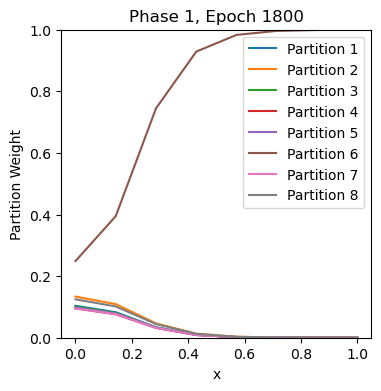

Phase 1, Epoch 1800, Loss: 0.002871, λ: 0.400000
Phase 1, Epoch 1810, Loss: 0.002865, λ: 0.400000
Phase 1, Epoch 1820, Loss: 0.002861, λ: 0.400000
Phase 1, Epoch 1830, Loss: 0.002856, λ: 0.400000
Phase 1, Epoch 1840, Loss: 0.002853, λ: 0.400000
Phase 1, Epoch 1850, Loss: 0.002849, λ: 0.400000
Phase 1, Epoch 1860, Loss: 0.002845, λ: 0.400000
Phase 1, Epoch 1870, Loss: 0.002841, λ: 0.400000
Phase 1, Epoch 1880, Loss: 0.002838, λ: 0.400000
Phase 1, Epoch 1890, Loss: 0.002834, λ: 0.400000
Phase 1, Epoch 1900, Loss: 0.002831, λ: 0.400000
Phase 1, Epoch 1910, Loss: 0.002827, λ: 0.400000
Phase 1, Epoch 1920, Loss: 0.002825, λ: 0.400000
Phase 1, Epoch 1930, Loss: 0.002821, λ: 0.400000
Phase 1, Epoch 1940, Loss: 0.002818, λ: 0.400000
Phase 1, Epoch 1950, Loss: 0.002815, λ: 0.400000
Phase 1, Epoch 1960, Loss: 0.002813, λ: 0.400000
Phase 1, Epoch 1970, Loss: 0.002810, λ: 0.400000
Phase 1, Epoch 1980, Loss: 0.002807, λ: 0.400000
Phase 1, Epoch 1990, Loss: 0.002804, λ: 0.400000


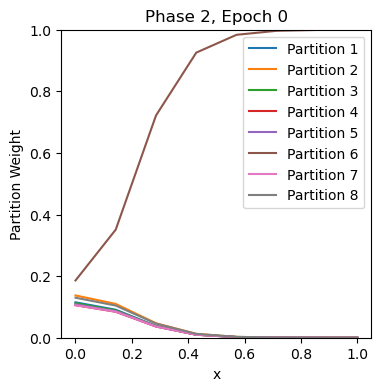

Phase 2, Epoch 0, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 10, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 20, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 30, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 40, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 50, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 60, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 70, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 80, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 90, Loss: 0.000000, λ: 0.000000


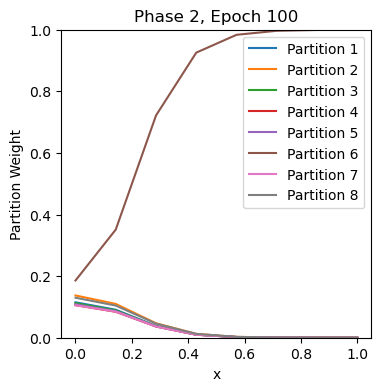

Phase 2, Epoch 100, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 110, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 120, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 130, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 140, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 150, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 160, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 170, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 180, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 190, Loss: 0.000000, λ: 0.000000


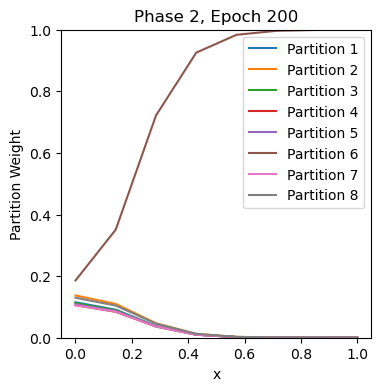

Phase 2, Epoch 200, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 210, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 220, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 230, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 240, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 250, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 260, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 270, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 280, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 290, Loss: 0.000000, λ: 0.000000


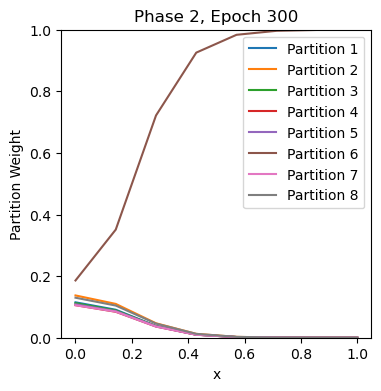

Phase 2, Epoch 300, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 310, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 320, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 330, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 340, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 350, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 360, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 370, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 380, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 390, Loss: 0.000000, λ: 0.000000


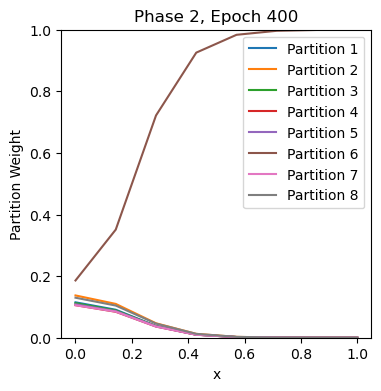

Phase 2, Epoch 400, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 410, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 420, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 430, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 440, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 450, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 460, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 470, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 480, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 490, Loss: 0.000000, λ: 0.000000


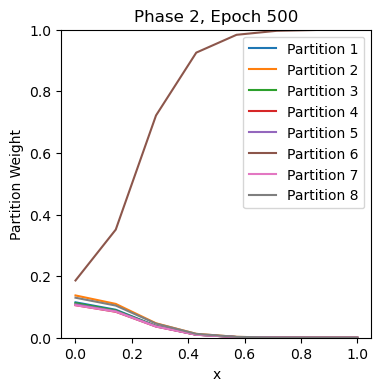

Phase 2, Epoch 500, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 510, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 520, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 530, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 540, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 550, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 560, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 570, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 580, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 590, Loss: 0.000000, λ: 0.000000


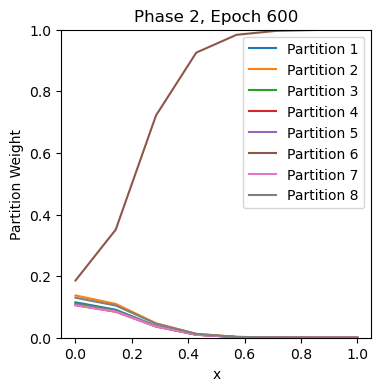

Phase 2, Epoch 600, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 610, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 620, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 630, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 640, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 650, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 660, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 670, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 680, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 690, Loss: 0.000000, λ: 0.000000


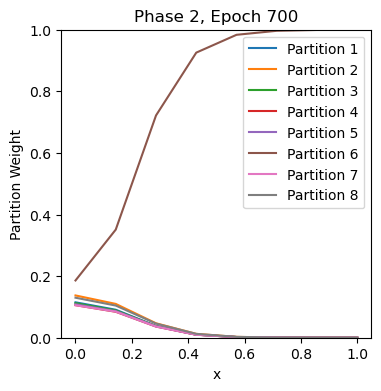

Phase 2, Epoch 700, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 710, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 720, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 730, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 740, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 750, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 760, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 770, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 780, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 790, Loss: 0.000000, λ: 0.000000


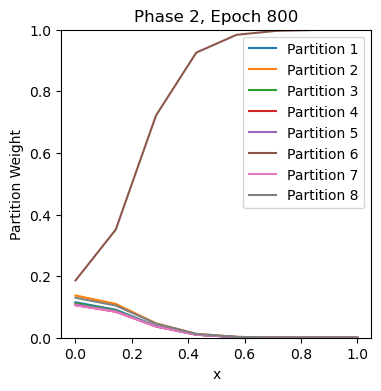

Phase 2, Epoch 800, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 810, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 820, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 830, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 840, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 850, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 860, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 870, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 880, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 890, Loss: 0.000000, λ: 0.000000


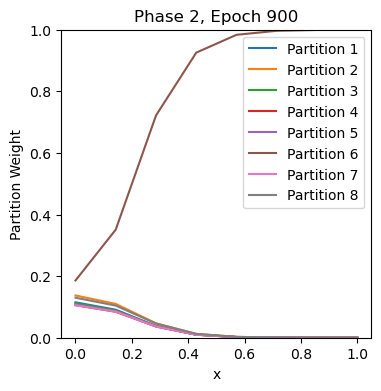

Phase 2, Epoch 900, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 910, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 920, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 930, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 940, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 950, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 960, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 970, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 980, Loss: 0.000000, λ: 0.000000
Phase 2, Epoch 990, Loss: 0.000000, λ: 0.000000


In [111]:
from jax import devices
print(devices())
x_train = jnp.linspace(0, 1, 8)
y_train = triangle_wave(x_train, p=3)

# Initialize network parameters
rng = jax.random.PRNGKey(42)
params = init_res_pou_net(rng, input_dim=1, num_partitions=8, hidden_dim=8, depth=4)

# Train
final_params = train_two_phase_lsgd(
    params,
    x_train,
    y_train,
    num_partitions=8,
    num_epochs_phase1=2000,
    num_epochs_phase2=1000,
    lambda_reg=0.4,
    rho=0.99,
    n_stag=50,
    lr_phase1=0.001,
    lr_phase2=0.001
)


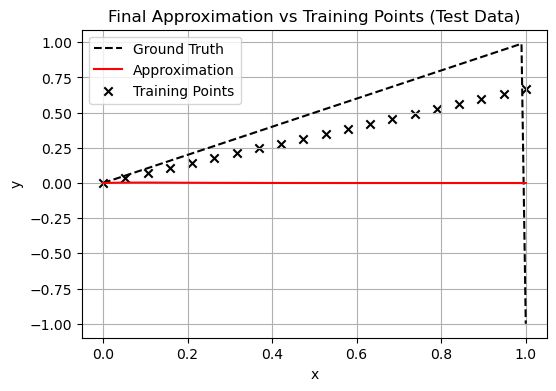

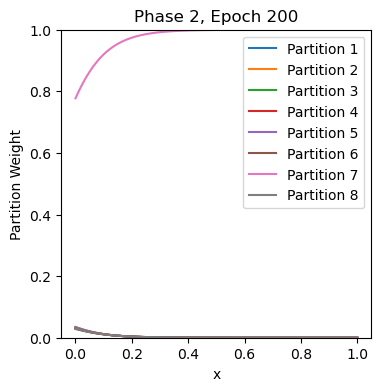

In [103]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np


def visualize_final_approximation(params, x_train, y_train, num_partitions=4):
    """
    Visualize the final approximation using the trained parameters.
    The plot will show both the training points and the approximation solution.
    
    params: trained network parameters (from init_res_pou_net)
    x_train: 1D array of training input data
    y_train: 1D array of target values (ground truth)
    num_partitions: the number of partitions in the model
    """
    # Convert x_train to JAX array and reshape for forward pass
    x_train_jnp = jnp.array(x_train).reshape(-1, 1)

    # Get the model's predictions (partition weights) for x_train
    partitions = apply_res_pou_net(params, x_train_jnp)  # shape: (N, num_partitions)

    # Convert to NumPy for local polynomial fitting
    partitions_np = np.array(partitions)  # shape: (N, num_partitions)

    # Fit local polynomials for the given partitions
    coeffs = fit_local_polynomials(np.array(x_train), np.array(y_train), partitions_np, num_partitions, lambda_reg=0.0)

    # Combine local polynomial predictions for x_train
    y_pred = np.zeros_like(y_train)
    for i in range(num_partitions):
        c0, c1 = coeffs[i]
        y_pred += partitions_np[:, i] * (c0 + c1 * x_train)

    # x_test
    x_test = jnp.linspace(0, 1, 100)

    # Get the model's predictions for x_test
    x_test_jnp = jnp.array(x_test).reshape(-1, 1)
    partitions_test = apply_res_pou_net(params, x_test_jnp)  # shape: (100, num_partitions)

    # Convert to NumPy for local polynomial fitting
    partitions_test_np = np.array(partitions_test)  # shape: (100, num_partitions)

    # Combine local polynomial predictions for x_test
    y_test_pred = np.zeros_like(x_test)
    for i in range(num_partitions):
        c0, c1 = coeffs[i]
        y_test_pred += partitions_test_np[:, i] * (c0 + c1 * x_test)

    # Calculate the true function values for comparison (e.g., triangle wave)
    y_true = triangle_wave(x_test, p=2)

    # Plot the ground truth, approximation, and training points
    plt.figure(figsize=(6, 4))

    # Plot the ground truth (true function values) on x_test
    plt.plot(x_test, y_true, label="Ground Truth", linestyle="--", color="black")

    # Plot the predicted approximation for x_test
    plt.plot(x_test, y_test_pred, label="Approximation", color="red")

    # Mark the training points (on the x_train, y_train data)
    plt.scatter(x_train, y_train, color="black", marker='x', label="Training Points")

    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Final Approximation vs Training Points (Test Data)")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    visualize_pou_weights(apply_res_pou_net, params, x_test, epoch=200, phase=2)  # Here we use epoch and phase for illustrative purposes

# Example usage (after training)
visualize_final_approximation(final_params, x_train, y_train, num_partitions=4)
